![OER Header](img/header.png)

# Synthetic Biomedical Data – Lesson 3: Irrelevant Features

Part of the *Microcredit Biomedical Data Generator* learning module. We focus on *irrelevant features* (pure noise) and how they impact model training and evaluation.

➡️ [Back to Lesson 3a: Irrelevant Features (Noise)](03a_irrelevant_features_nois.ipynb)
➡️ [Module Overview (README)](../README.md)

---

## Recap from Lesson 3a
You:
- Generated synthetic biomedical datasets with informative and noise features.
- Visualized feature distributions and class separability.
- Evaluated cohen's d effect size for informative features and noise features.
- Understood how effect size ranking is influenced by feature dimension and sample size.

Now we focus on the effect of the dimension and distribution of **irrelevant features** — variables that carry *no* useful information about the label.


If too many irrelevant features are present, they can:
- Make it harder to identify true biomarkers. Too many irrelevant features can hide the true signal.
- Increase model complexity and training time and make feature selection more difficult.
- Lead to overfitting if models start learning patterns in the noise.

Synthetic data allows us to deliberately add irrelevant features to test how models and methods cope with them.

## What you'll learn
In this lesson, we will add irrelevant features to a synthetic dataset
and see how they effect model performance and feature correlations. After completing this notebook, you will be able to:
- Add purely irrelevant features with configurable distributions (normal, uniform, Laplace).
- Visualize the distributions of irrelevant features.
- Evaluate how increasing the number of irrelevant features affects model performance using cross-validated balanced accuracy.
- Analyze spurious correlations between irrelevant features and the label.

### Code – Imports, Installation/Upgrade

If needed, install  or upgrade the package `biomedical-data-generator`(uncomment in managed environments) via:
```python
%pip install -U biomedical-data-generator
```

In [1]:
# Standard package imports
import nb_imports as nb
# Set plotting style
from nb_setup import apply_style; apply_style()

## Data configuration from irrelevant features lesson

In [2]:
n_noise_features = 1200  # number of irrelevant features to add
n_class_samples = 15  # samples per class, analogous to a small biomedical study
cfg_noise_normal = nb.DatasetConfig(
    n_samples=n_class_samples * 2,
    n_informative=8,
    n_noise=n_noise_features,
    n_classes=2,
    class_counts={0: n_class_samples, 1: n_class_samples},  # balanced classes
    class_sep=1.2,  # keep consistent with the baseline
    feature_naming="prefixed",  # i1..i8, n1..n12
    noise_distribution=nb.NoiseDistribution.normal,
    noise_scale=1.0,  # std for normal noise
    random_state=1908,
)
Xn, yn, meta_n = nb.generate_dataset(cfg_noise_normal, return_dataframe=True)

# Combine X and y for plotting
X_noise = Xn.copy()
X_noise.insert(0, "class", yn)

# Step 1 - Inspect noise distributions
## Normal noise
With `noise_distribution="normal"` and `noise_scale=1.0`, we expect:
- Approximately zero mean and unit variance for noise columns.
- No visible class separation in the noise columns.
- Similar spread across noise columns, up to sampling variability.


<Axes: xlabel='n26', ylabel='Density'>

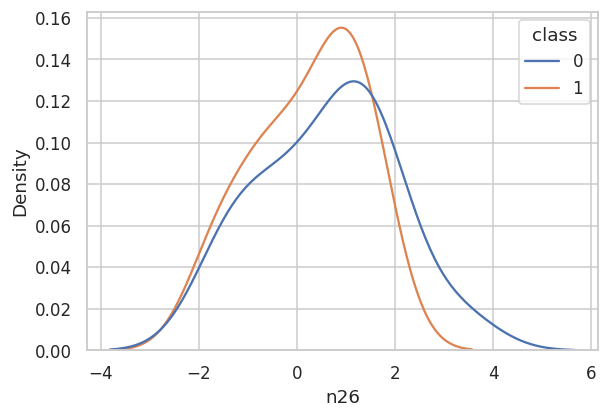

In [3]:
nb.sns.kdeplot(data=X_noise, x="n26", hue="class")

## Uniform noise
Now we switch to `noise_distribution="uniform"`.
Here, `noise_scale` acts as the **half-width** of the interval, i.e. values are roughly in `[-scale, +scale]`.

We’ll use `noise_scale=2.0`, so noise features should mostly lie in `[-2, 2]` with a flat-ish density.

In [4]:
cfg_noise_uniform = nb.DatasetConfig(
    n_samples=10000, # set a larger sample size for better empirical estimates
    n_informative=8,
    n_noise=12,
    class_counts={0: 5000, 1: 5000},  # balanced classes
    noise_distribution=nb.NoiseDistribution.uniform,
    noise_scale=2.0,          # half-width for uniform
    random_state=42,
)
Xu, yu, meta_u = nb.generate_dataset(cfg_noise_uniform, return_dataframe=True)
Xu.insert(0, "class", yu)

# Empirical min/max of first 5 noise columns to verify ~[-2, 2]
mins = Xu[[f"n{k}" for k in range(1, 6)]].min().round(3)
maxs = Xu[[f"n{k}" for k in range(1, 6)]].max().round(3)
display(nb.pd.DataFrame({"min": mins, "max": maxs}))

,min,max
n1,-1.999,1.999
n2,-2.000,2.000
n3,-2.000,2.000
n4,-1.998,1.999
n5,-2.000,2.000


### Uniform noise expectations

With `noise_distribution="uniform"` and `noise_scale=2.0`, values are roughly in **`[-2, 2]`**.
You should observe:
- Empirical **min/max** close to −2 and +2 (but not equal—finite samples fall short of true bounds).
- **Nearly constant density** within the interval, unlike the bell shape of normal noise.

<Axes: xlabel='n2', ylabel='Count'>

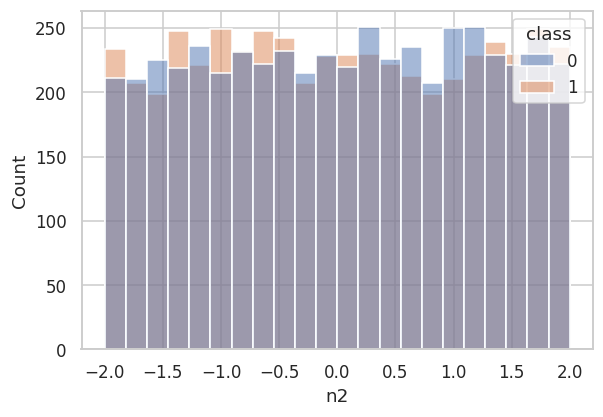

In [5]:
nb.sns.histplot(data=Xu, x="n2", hue="class")

# Step 2 — Cross-validated model performance

We now study how *increasing the number of irrelevant (noise) features* affects model performance. We measure how a simple linear classifier (Logistic Regression) behaves under **Stratified 5-Fold CV** as we increase the number of noise features.

**Plan**
1. Keep the true signal fixed: 8 informative features, same effect size/separability.
2. Vary the number of **pure noise** features: e.g. `k ∈ {0, 50, 200, 1000}`.
3. Train a simple linear classifier (Logistic Regression) **with scaling** and evaluate via **Stratified 5-Fold CV**. We keep the model fixed to isolate the effect of dimensionality.
4. Only one factor changes: the number of irrelevant features.
5. Track: **Balanced accuracy** (robust to small class imbalances)

In [6]:
# Experiment configuration
# Fixed signal & CV settings
SEED = 42
N_SAMPLES = 30
N_INFORMATIVE = 8
CLASS_SEP = 1.2

# Noise counts to sweep over
NOISE_COUNTS = [0, 50, 200, 1000, 10000]

# Estimator: scale -> logistic regression (binary)
# liblinear is robust for small-sample, L2 by default
ESTIMATOR = nb.make_pipeline(
    nb.RobustScaler(),
    nb.LogisticRegression(solver="liblinear", random_state=SEED, max_iter=2000)
)

CV = nb.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
SCORER = nb.make_scorer(nb.balanced_accuracy_score)

### Why logistic regression + scaling?

- **Logistic Regression** is a transparent linear baseline; with L2 regularization it copes reasonably with moderate noise.
- **RobustScaler** avoids feature-scale dominance and reduces optimization issues. Robust scaling (median + IQR) is less sensitive to outliers than standard scaling (mean + std).
- The pipeline ensures **no data leakage**: scaling parameters are learned **inside** each CV fold.
- Alternatives to try later:
  - **Tree ensembles** (e.g. Random Forests) for non-linear baselines.
  - **Elastic Net** for embedded sparsity (tuning needed).

In [7]:
# Dataset factory (using biomedical-data-generator)
def make_dataset(n_noise: int,
                 noise_dist = nb.NoiseDistribution.normal,
                 noise_scale: float = 1.0,
                 *,
                 n_samples: int = N_SAMPLES,
                 n_informative: int = N_INFORMATIVE,
                 class_sep: float = CLASS_SEP,
                 seed: int = SEED):
    """
    Build a dataset with a fixed informative block and variable number of pure-noise features.
    Returns: (X_df, y_np, meta)
    """
    cfg1 = nb.DatasetConfig(
        n_samples=n_samples,
        n_informative=n_informative,
        n_noise=n_noise,
        class_counts={0: n_samples/2, 1: n_samples/2},  # balanced classes
        class_sep=class_sep,
        feature_naming="prefixed",      # i1..iK, n1..nK
        noise_distribution=noise_dist,  # "normal" | "uniform" | "laplace"
        noise_scale=noise_scale,
        random_state=seed,
    )
    X_df, y_np, meta_data = nb.generate_dataset(cfg1, return_dataframe=True)
    return X_df, y_np, meta_data

### Guarding against leakage in CV

By wrapping preprocessing and the estimator in a **single pipeline** and passing it to `cross_val_score`, we guarantee that:
- **Scaling** and **model fitting** occur **only on the training folds**.
- The held-out fold remains unseen until scoring, yielding **honest** performance estimates.


In [8]:
# CV evaluation helper
def evaluate_cv(X_df: nb.pd.DataFrame, y_np: nb.np.ndarray,
                estimator=ESTIMATOR,
                cv=CV,
                scorer=SCORER) -> tuple[float, float]:
    """
    Returns (mean_bal_acc, std_bal_acc) from K-fold CV.
    """
    scores = nb.cross_val_score(estimator, X_df, y_np, cv=cv, scoring=scorer, n_jobs=None)
    return float(scores.mean()), float(scores.std())

### Run the sweep over noise counts, collecting balanced accuracy

In [9]:
def run_sweep(noise_counts, noise_dist, noise_scale) -> nb.pd.DataFrame:
    results = []
    for k_noise in noise_counts:
        Xk, yk, meta_k = make_dataset(n_noise=k_noise, noise_dist=noise_dist, noise_scale=noise_scale)
        mean_ba, std_ba = evaluate_cv(Xk, yk)
        results.append({
            "dist": str(noise_dist),
            "scale": noise_scale,
            "n_noise": k_noise,
            "n_informative": len(meta_k.informative_idx),
            "bal_acc_mean": mean_ba,
            "bal_acc_std": std_ba,
        })
    return nb.pd.DataFrame(results).sort_values("n_noise").reset_index(drop=True)

result_df = run_sweep(NOISE_COUNTS, nb.NoiseDistribution.normal, 1.0)

### What trends to expect

**Balanced accuracy** typically **decreases** as `n_noise` increases (harder signal recovery).

### Plot results

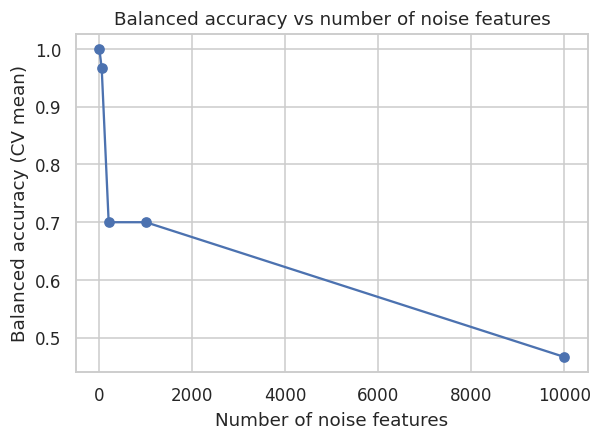

In [10]:
# Balanced accuracy vs number of noise features
nb.plt.figure()
nb.plt.plot(result_df["n_noise"], result_df["bal_acc_mean"], marker="o")
nb.plt.title("Balanced accuracy vs number of noise features")
nb.plt.xlabel("Number of noise features")
nb.plt.ylabel("Balanced accuracy (CV mean)")
nb.plt.show()

### Reading the plots carefully

- Expect **non-monotonic fluctuations** due to finite-sample randomness—don’t over-fit to a single curve.
- Look for the **overall slope**: does performance degrade roughly as dimensionality rises?
- If a method looks unusually stable, verify you are **not leaking information** and that regularization is properly tuned.

### Computational notes

- This sweep is lightweight (single model, 5-fold CV).
- As you add methods (e.g., nested CV, repeated subsampling, multiple models), runtime will grow quickly.
- Keep random seeds fixed for **comparability**, and cache intermediate results when exploring many settings.

### Interpretation checklist

- **Performance drop**: As `n_noise` grows, balanced accuracy should typically **decrease** unless regularization and sample size are strong.
- **Sample size matters**: With fixed effect size, increasing `n_samples` generally improves both performance and discovery metrics.
- **Regularization**: Linear models with proper regularization can resist some noise, but the *curse of dimensionality* still applies.

### Biomedical context: why this matters

Omics datasets (e.g., gene expression, proteomics, methylation) often have **p ≫ n**:
- Thousands of features with **few dozens of samples**.
- Many features are unrelated to the phenotype—i.e., **irrelevant** for prediction.

Understanding how irrelevant features affect **generalization** and **feature discovery** helps you:
- Choose appropriate **regularization** and **model families**,
- Design **feature selection** protocols that avoid false discoveries,
- Plan for **validation** on independent cohorts.


# Step 3 — Comparing noise distributions

Repeat the sweep with:
- `noise_distribution="uniform", noise_scale=2.0` (values roughly in `[-2, 2]`)
- `noise_distribution="laplace", noise_scale=1.0` (heavier tails)

Then compare curves (balanced accuracy) across distributions.

In [11]:
df_uniform = run_sweep(NOISE_COUNTS, nb.NoiseDistribution.uniform, 2.0)
df_laplace = run_sweep(NOISE_COUNTS, nb.NoiseDistribution.laplace, 1.0)
display(df_uniform, df_laplace)

,dist,scale,n_noise,n_informative,bal_acc_mean,bal_acc_std
0,NoiseDistribution.uniform,2.0,0,8,1.000000,0.000000
1,NoiseDistribution.uniform,2.0,50,8,0.866667,0.124722
2,NoiseDistribution.uniform,2.0,200,8,0.800000,0.124722
3,NoiseDistribution.uniform,2.0,1000,8,0.700000,0.194365
4,NoiseDistribution.uniform,2.0,10000,8,0.666667,0.182574


,dist,scale,n_noise,n_informative,bal_acc_mean,bal_acc_std
0,NoiseDistribution.laplace,1.0,0,8,1.000000,0.000000
1,NoiseDistribution.laplace,1.0,50,8,0.833333,0.149071
2,NoiseDistribution.laplace,1.0,200,8,0.733333,0.200000
3,NoiseDistribution.laplace,1.0,1000,8,0.466667,0.163299
4,NoiseDistribution.laplace,1.0,10000,8,0.600000,0.169967


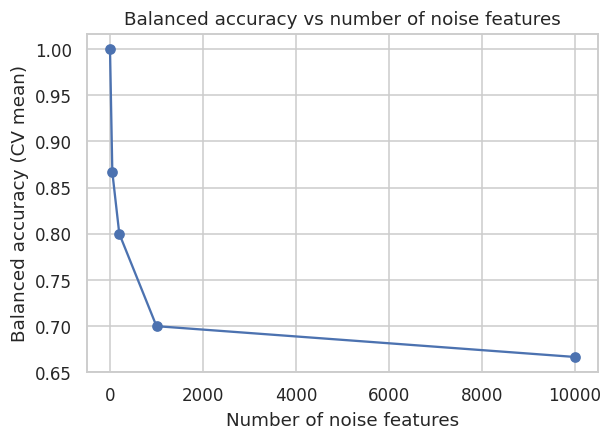

In [12]:
# Balanced accuracy vs number of uniform noise features
nb.plt.figure()
nb.plt.plot(df_uniform["n_noise"], df_uniform["bal_acc_mean"], marker="o")
nb.plt.title("Balanced accuracy vs number of noise features")
nb.plt.xlabel("Number of noise features")
nb.plt.ylabel("Balanced accuracy (CV mean)")
nb.plt.show()

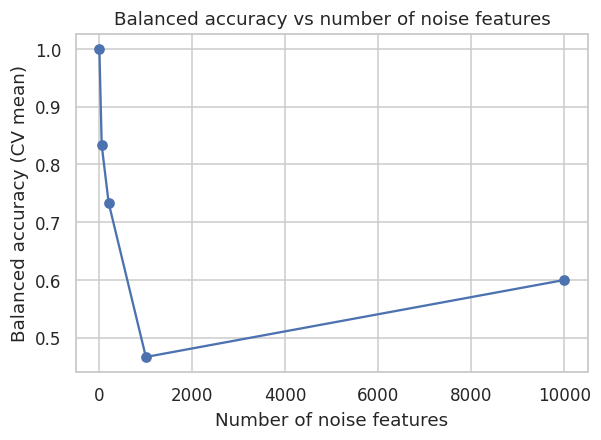

In [13]:
# Balanced accuracy vs number of laplace noise features
nb.plt.figure()
nb.plt.plot(df_laplace["n_noise"], df_laplace["bal_acc_mean"], marker="o")
nb.plt.title("Balanced accuracy vs number of noise features")
nb.plt.xlabel("Number of noise features")
nb.plt.ylabel("Balanced accuracy (CV mean)")
nb.plt.show()

### Comparing noise distributions

- **Uniform** noise (bounded support) usually yields tighter extremes than normal at small `n`, reducing outlier risks.
- **Laplace** noise (heavier tails) increases the chance of **extreme values**, which can inflate spurious correlations and destabilize rankings.
- When sweeping distributions, keep **`n_samples`, `n_informative`, and `class_sep`** fixed to isolate the distributional effect.


In [14]:
# Optional: quick train/test split on the normal-noise dataset to see if noise hurts performance
X_tr, X_te, y_tr, y_te = nb.train_test_split(Xn.values, yn, test_size=0.3, random_state=42, stratify=yn)

clf = nb.make_pipeline(nb.StandardScaler(), nb.LogisticRegression(max_iter=500, random_state=42))
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print("Logistic Regression accuracy (normal noise, 12 feats):", round(nb.accuracy_score(y_te, pred), 3))

Logistic Regression accuracy (normal noise, 12 feats): 0.556


## Reflection
**Model performance** (if you ran the optional classifier):
  - How much did adding noise affect classification accuracy?
  - What might happen if you add *hundreds* of noise features?

**Think ahead**:
In real biomedical studies, many measured variables are irrelevant.
Why is it important to detect and filter them before applying complex models?

# Step 4 Spurious correlations

Irrelevant features should be **uncorrelated** with `y` (up to sampling noise) and show no systematic correlation with informative features.

We’ll compute:
- Absolute correlation between each **noise** feature and the **label** `y`.
- Maximum absolute correlation between **noise** and **informative** features.


In [15]:
# Work on the uniform-noise dataset (Xu, yu, meta_u)
informative_columns = [f"i{k}" for k in range(1, len(meta_u.informative_idx) + 1)]
noise_columns = [f"n{k}" for k in range(1, len(meta_u.noise_idx) + 1)]

# Correlation of noise with the label (point-biserial via pandas corr with numeric y)
yu_numeric = nb.pd.Series(yu, name="y").astype(float)

noise_y_corr = (
    Xu[noise_columns].apply(lambda s: s.corr(yu_numeric)).abs().sort_values(ascending=False)
)
print("Top 5 |abs(corr(noise, y))| (should be modest due to randomness):")
display(noise_y_corr.head(5).round(3))

# Max |corr| between noise and any informative feature
corr_matrix = Xu[informative_columns + noise_columns].corr().abs()
max_noise_inf = corr_matrix.loc[informative_columns, noise_columns].max().sort_values(ascending=False)
print("Top 5 max |corr| between informative and noise (should be modest):")
display(max_noise_inf.head(5).round(3))

Top 5 |abs(corr(noise, y))| (should be modest due to randomness):


n9    0.018
n1    0.012
n8    0.012
n4    0.010
n2    0.009
dtype: float64

Top 5 max |corr| between informative and noise (should be modest):


n4     0.024
n1     0.023
n2     0.022
n12    0.021
n11    0.019
dtype: float64

### Spurious correlations grow with dimensionality

Even if each noise feature is uninformative, the **largest absolute correlation** among many noise variables can be non-trivial **by chance**.

Rule of thumb (for intuition): the maximum spurious correlation scales roughly like
$$
\max_j \lvert r_{j,y}\rvert \sim \sqrt{\tfrac{2\log p}{n}}
$$
where \(p\) is the number of features and \(n\) the sample size.


➡️ As you add more noise features or reduce sample size, **chance correlations** become more prominent.


## Quick Takeaway
- **Irrelevant features** add no predictive value and can **dilute** signal. Synthetic data allows us to control how much noise exists, so we can test how methods behave in high-noise vs. low-noise scenarios.
- As the number of irrelevant features increases, model performance (e.g., balanced accuracy) typically **decreases** due to the *curse of dimensionality*.
- Different noise distributions (normal, uniform, Laplace) have distinct characteristics that can affect model training and evaluation.
- Spurious correlations between noise features and the label can arise by chance, especially as dimensionality increases.
- In high-noise settings, feature selection (see MC XXX) becomes crucial.

## Next Steps

In **Lesson 3c: Correlated Features**, you will:
- Simulate features that **move together** (e.g., biological pathways).
- Visualize correlation structures.
- See how **redundancy** complicates analysis.

➡️ Continue with: **[`03c_correlated_features.ipynb`](03c_correlated_features.ipynb)`**
